# RBM Analysis
Jupyter notebook which analyzes the results of our trained RBM model used to predict the ground state configuration of a many-body quantum system described by the periodic TFIM with Hamiltonian

$\hat{H} = -\sum^{N}_{i=1} \hat{\sigma}^{z}_{i} \hat{\sigma}^{z}_{i+1} - h \sum_{i=1}^{N} \hat{\sigma}^{x}_{i}$

Where $\hat{\sigma}_{i}^{z}$ and $\hat{\sigma}_{i}^{x}$ are Pauli operators acting on the $i^{th}$ qubit. Here, we can assume that we're normalized wrt the coupling constant $J$, so that the transverse field strength is really in terms of $J$. 

First, load up the requiste packages.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import hamils
from rbm import ResBoltMan 
import yaml 
from yaml import Loader

Initialize and load up the trained RBM

In [102]:
# load up parameters about our training. 
index = 5
stream = open(f"configs/train{index}.yaml", 'r')
cnfg = yaml.load(stream, Loader=Loader)

N = cnfg['N']
h = cnfg['h']
num_hid=cnfg['num_hid']
name = cnfg['name']
load_direc = cnfg['save_direc']

trained_RBM = ResBoltMan(N, num_hid, name, h=h)
trained_RBM.load_rbm(name, f'models/{load_direc}')
print(name)

# Make sure to update the partition function to reflect the newly loaded parameters, too!

trained_RBM.update_part_func()

rbm_5


Calculate the variance and the mean of the energy expectation value. 

In [103]:
mean_expect, var_expect = trained_RBM.get_mean_var(1000)
print(f"Mean: {mean_expect}, Variance: {var_expect}")

Mean: (-6.270763189486103+0j), Variance: 0.2814941855794244


We can also reconstruct the ground state by computing the probability amplitudes and taking the weighted sum of all of the basis states. 

In [104]:
from hamils import gen_basis_state

ground_state_amp_reconst = trained_RBM.compute_prob_basis() # Probability amplitudes
basis_state_rep = gen_basis_state(N)
basis_states =[trained_RBM.gen_basis_state(bs_rep) for bs_rep in basis_state_rep] 

# We verify that the probabilities are properly normalized here 

ground_state_rec = np.sum([basis_states[ii]*ground_state_amp_reconst[ii] for ii in range(2**N)], axis=1)
#print(ground_state_rec)

#print(np.sum((ground_state_amp_reconst)**2))

For comparision, determine the ground state using Exact Diagonalization

In [105]:
from hamils import compute_hamiltonian
from numpy.linalg import eigh

theoretical_hamiltonian = compute_hamiltonian(N, h)
gnomeState = np.zeros(N, dtype=np.complex128)
eigSpectrum, eigSol = eigh(theoretical_hamiltonian)
ground_state_eigenvalue = np.min(eigSpectrum)
ground_state_index= np.argmin(eigSpectrum)
ground_state = eigSol[ground_state_index]

print(f'Actual Expected Energy: {ground_state_eigenvalue}')

Actual Expected Energy: -6.4721359549995805


Make a plot of the histogram of amplitude distributions 

C:\Users\tjaou104\AppData\Local\anaconda3\Lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


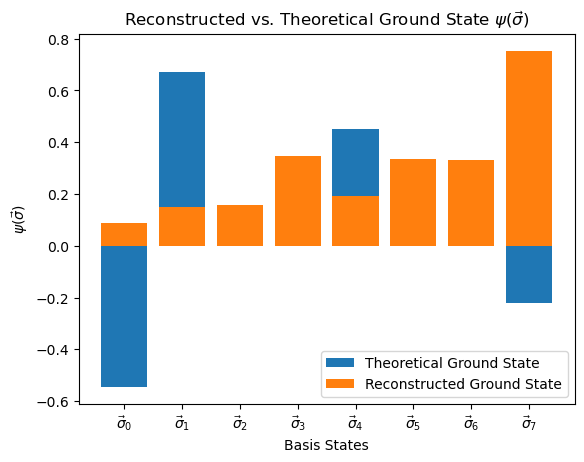

In [101]:
import pandas as pd
# Create a DataFrame in long-form

labels = [r'$\vec{\sigma}_0$', r'$\vec{\sigma}_1$', r'$\vec{\sigma}_2$', r'$\vec{\sigma}_3$', r'$\vec{\sigma}_4$', r'$\vec{\sigma}_5$', r'$\vec{\sigma}_6$', r'$\vec{\sigma}_7$']

fig, ax = plt.subplots()
ax.bar(labels, ground_state, label='Theoretical Ground State')
ax.bar(labels, ground_state_rec, label='Reconstructed Ground State')  # stacked on top of array1

ax.set_xlabel('Basis States')
ax.set_ylabel(r'$\psi(\vec{\sigma})$')
ax.set_title(r'Reconstructed vs. Theoretical Ground State $\psi(\vec{\sigma})$')
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.legend()

plt.savefig('rbm_theory_vs_rec.pdf', format='pdf', bbox_inches='tight')